# Relatório de Análise Exploratória – Alfabetização de Mulheres no Brasil (Censo 2022 & INEP 2022)

## **1. Introdução**

Neste relatório, demonstro a aplicação prática dos dados obtidos através de um projeto de extração (ETL) que desenvolvi e disponibilizei no GitHub.

Optei por analisar os dados sob o viés da **alfabetização** por considerar este um indicador relevante para compreender o desenvolvimento humano e social. A educação é uma ferramenta essencial para entender a sociedade, orientar políticas públicas e revelar padrões regionais.

Nesta análise exploratória, investigo as declarações do Censo 2022 sobre alfabetização no Brasil, com um foco específico no recorte de gênero.

A pergunta central que guia a minha análise é:
**Quantas mulheres se autodeclararam alfabetizadas no Brasil em comparação aos homens?**

Para responder a esta questão, utilizei:
* **Censo Demográfico 2022 (IBGE):** para quantificar homens e mulheres adultos alfabetizados por município e Unidade Federativa (UF).
* **Censo Escolar 2022 (INEP):** para analisar matrículas associadas ao processo de alfabetização (anos iniciais do fundamental e EJA fundamental), também segmentadas por sexo e UF.

O meu objetivo final é identificar se existem desigualdades de género, como estas diferenças variam entre estados e municípios, e de que forma se relacionam com o fluxo educacional captado pelo INEP.

## **2. Fontes de Dados**

Para este estudo, utilizei os dados que extraí e tratei no seguinte projeto:
> [ETL Censo BigQuery - Mulheres Brasil](https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil)

### **2.1. Censo 2022 (Censo Demográfico – IBGE)**
* **Nível de agregação:** Município.
* **População:** Padrão **autodeclarativo** do Censo.
* **Definição de Alfabetização:** Resposta afirmativa à pergunta "Sabe ler e escrever?".
* **Variáveis relevantes selecionadas:**
    * Geografia: `id_municipio`, `nome_municipio`, `sigla_uf`
    * Demografia: `populacao_homens`, `populacao_mulheres`, `populacao_total`

---

### **2.2. INEP 2022 (Censo Escolar)**
Utilizei esta fonte para examinar as matrículas em níveis de ensino associados ao processo de alfabetização:
* **QT_MAT_FUND_AI:** Matrículas nos anos iniciais do ensino fundamental.
* **QT_MAT_EJA_FUND:** Matrículas da EJA (Educação de Jovens e Adultos) no nível fundamental.
* **Matrículas por sexo:** `QT_MAT_BAS_FEM` e `QT_MAT_BAS_MASC`.
* **Variáveis geográficas:** `id_municipio`, `SG_UF`, `NO_UF`.

O cruzamento destes dados permite-me observar se o padrão de alfabetização autodeclarado se reflete também nas matrículas escolares formais.

---

## **3. Metodologia**

### **Critérios adotados**
* **População analisada:** Baseada inteiramente na declaração no Censo 2022.
* **Unificação das bases (Censo–INEP):** Realizada através da chave `id_municipio`.
* **Filtros:** Não apliquei filtros adicionais (como escolaridade mínima) para manter a aderência estrita à métrica oficial de alfabetização do IBGE.

### **Indicadores calculados**
Durante a análise, construí os seguintes indicadores:
* Taxa de alfabetização feminina por UF.
* Taxa de alfabetização masculina por UF.
* **Gap de género:** Diferença entre a `taxa_mulheres` e a `taxa_homens`.
* Comparação entre alfabetização (stock/Censo) e matrículas (fluxo/INEP).
* Detalhamento dos dados a nível municipal.

In [1]:
# 1. Bibliotecas necessárias
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest


In [2]:
# 2. Configurações de diretórios e caminhos
"""
Conforme o informado, os dados aqui usados são de uma camada "confiável" (trusted), extraído por outro projeto que criou 
uma pipeline de extração e tratamento dos dados. Disponível em:
  > https://github.com/patriciacarbri/etl-censo-bigquery-mulheres-brasil.

"""
PATH_BQ = "data/censo_2022_trusted.parquet"
PATH_INEP = "data/inep_2022_trusted.parquet"
OUT_DIR = "data/analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# 3. Carregamento dos dados
print('Carregando arquivos...')

df_censo = pd.read_parquet(PATH_BQ)
df_inep = pd.read_parquet(PATH_INEP)


print('Arquivos carregados:')
print('Censo (df_censo):', df_censo.shape)
print('INEP (df_inep):', df_inep.shape)


Carregando arquivos...
Arquivos carregados:
Censo (df_censo): (779800, 8)
INEP (df_inep): (178346, 32)


In [4]:
# Apresentação da colunas dos dados extraídos:

print('\nColunas principais do Censo (bq):')
print(df_censo.columns.tolist())


print('\nColunas principais do INEP (df_inep):')
print(df_inep.columns.tolist()[:50])



Colunas principais do Censo (bq):
['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'cor_raca', 'grupo_idade', 'alfabetizacao', 'populacao']

Colunas principais do INEP (df_inep):
['NU_ANO_CENSO', 'NO_REGIAO', 'CO_REGIAO', 'NO_UF', 'SG_UF', 'CO_UF', 'NO_MUNICIPIO', 'id_municipio', 'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_INF_CRE', 'QT_MAT_INF_PRE', 'QT_MAT_FUND', 'QT_MAT_FUND_AI', 'QT_MAT_FUND_AF', 'QT_MAT_MED', 'QT_MAT_PROF', 'QT_MAT_PROF_TEC', 'QT_MAT_EJA', 'QT_MAT_EJA_FUND', 'QT_MAT_EJA_MED', 'QT_MAT_ESP', 'QT_MAT_ESP_CC', 'QT_MAT_ESP_CE', 'QT_MAT_BAS_FEM', 'QT_MAT_BAS_MASC', 'QT_MAT_BAS_ND', 'QT_MAT_BAS_BRANCA', 'QT_MAT_BAS_PRETA', 'QT_MAT_BAS_PARDA', 'QT_MAT_BAS_AMARELA', 'QT_MAT_BAS_INDIGENA']


Ao explorar os dados extraídos do Censo, identifiquei que estes oferecem um perfil demográfico completo, permitindo cruzamentos por sexo, grupo de idade, cor/raça e a própria autodeclaração de alfabetização.

Por outro lado, os dados do INEP apresentam uma granularidade distinta, focada no volume e tipologia das matrículas. Visto que o meu estudo se concentra na alfabetização, filtrei e utilizei apenas as colunas do Censo Escolar que representam diretamente esta etapa de ensino, descartando variáveis que não contribuiriam para a resposta da minha pergunta central.

Padronização mínima dos dados

> Como os dados já estão em formato "trusted" neste notebook serão aplicadas somente padronizações mínimas necessárias para a análise.

In [5]:
# Nomes de colunas padronizados:

# Padronização de nomes de colunas do Inep
df_inep = df_inep.rename(columns={
    'sg_uf': 'sigla_uf',
    'NO_MUNICIPIO': 'nome_municipio'})

# Garantir id_municipio como string 
for d in (df_censo, df_inep):
    if 'id_municipio' in d.columns:
        d['id_municipio'] = d['id_municipio'].astype(str)


### 1- Panorama geral da alfabetização feminina no Brasil**

Perguntas que você definiu:

1. **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**
2. **Como a alfabetização feminina varia entre UFs ?**
3. **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**
 

**Objetivo do capítulo:**
Criar o retrato inicial. Gráficos + mapas.

#### **Como é distribuída a população feminina alfabetizada por raça dentro dos municípios e capitais?**

In [6]:
# 1) Dicionário de capitais (inclui DF)
capitais = {
    "Rio Branco": "AC", "Maceió": "AL", "Macapá": "AP", "Manaus": "AM",
    "Salvador": "BA", "Fortaleza": "CE", "Brasília": "DF", "Vitória": "ES",
    "Goiânia": "GO", "São Luís": "MA", "Cuiabá": "MT", "Campo Grande": "MS",
    "Belo Horizonte": "MG", "Belém": "PA", "João Pessoa": "PB", "Curitiba": "PR",
    "Recife": "PE", "Teresina": "PI", "Rio de Janeiro": "RJ", "Natal": "RN",
    "Porto Alegre": "RS", "Porto Velho": "RO", "Boa Vista": "RR", "Florianópolis": "SC",
    "São Paulo": "SP", "Aracaju": "SE", "Palmas": "TO"
}

In [7]:
df_censo.head()

,id_municipio,nome_municipio,sigla_uf,sexo,cor_raca,grupo_idade,alfabetizacao,populacao
0,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Alfabetizadas,0
1,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,15 a 19 anos,Não alfabetizadas,0
2,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Alfabetizadas,2
3,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,20 a 24 anos,Não alfabetizadas,0
4,1100015,Alta Floresta D'Oeste,RO,Homens,Amarela,25 a 34 anos,Alfabetizadas,5


In [8]:
# 2) Filtrar capitais no df_censo
df_censoCapitais = df_censo[
    (df_censo['nome_municipio'].isin(capitais.keys()))
].copy()


In [9]:
# garantir colunas mínimas
required = ['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo', 'populacao']
for c in required:
    if c not in df_censo.columns:
        df_censo[c] = None

# normalizar sexo (tolerante a variações)
sexo_norm = (
    df_censo['sexo']
    .astype(str)
    .str.strip()
    .str.lower()
    .fillna('')
    .map(lambda s: 'Homens' if 'hom' in s else ('Mulheres' if 'mul' in s else s))
)
df_censo['sexo'] = sexo_norm

# garantir populacao numérica
df_censo['populacao'] = pd.to_numeric(df_censo['populacao'], errors='coerce').fillna(0).astype(int)

# agregar: somar populacao por id_municipio, nome_municipio, sigla_uf e sexo
agg = (
    df_censo
    .groupby(['id_municipio', 'nome_municipio', 'sigla_uf', 'sexo'], dropna=False)['populacao']
    .sum()
    .reset_index()
)

# pivotar para ter colunas por sexo
pivot = (
    agg
    .pivot_table(
        index=['id_municipio', 'nome_municipio', 'sigla_uf'],
        columns='sexo',
        values='populacao',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

# renomear/garantir colunas esperadas
pivot = pivot.rename(columns={
    'Homens': 'populacao_homens',
    'Mulheres': 'populacao_mulheres'
})

# garantir existência das colunas (se faltou algum sexo)
if 'populacao_homens' not in pivot.columns:
    pivot['populacao_homens'] = 0
if 'populacao_mulheres' not in pivot.columns:
    pivot['populacao_mulheres'] = 0

pivot['populacao_homens'] = pivot['populacao_homens'].astype(int)
pivot['populacao_mulheres'] = pivot['populacao_mulheres'].astype(int)

# diferença mulheres - homens
pivot['dif_mulheres_homens'] = pivot['populacao_mulheres'] - pivot['populacao_homens']

# resultado final
df_censoCapitais = pivot[['id_municipio', 'nome_municipio', 'sigla_uf',
                          'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].copy()


In [10]:
# 3) Ranking (diferença absoluta mulheres - homens) e tabela resultante
df_censoCapitais['dif_mulheres_homens'] = df_censoCapitais['populacao_mulheres'] - df_censoCapitais['populacao_homens']
df_ranking = df_censoCapitais.sort_values('dif_mulheres_homens', ascending=False).reset_index(drop=True)


Ao aprofundar a análise para o nível das cidades brasileiras, observei que as diferenças de gênero persistem, mas comportam-se de maneiras distintas dependendo do desempenho geral do município.

Identifiquei que as 10 cidades que lideram o ranking de alfabetização são todas capitais. Nelas, mantém-se o padrão nacional: as mulheres apresentam taxas de alfabetização superiores às dos homens.

No entanto, notei uma inversão de cenário ao olhar para a base da lista. Nos 10 municípios com os menores índices de alfabetização do país, os dados mostram que a taxa de alfabetização masculina supera a feminina, conforme detalho nas tabelas abaixo.

In [11]:
df_ranking[['nome_municipio',  'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].head(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
0,São Paulo,SP,4391453,5106518,715065
1,Rio de Janeiro,RJ,2357034,2821689,464655
2,Salvador,BA,896709,1115241,218532
3,Fortaleza,CE,897973,1081420,183447
4,Belo Horizonte,MG,892949,1063235,170286
5,Brasília,DF,1070978,1212089,141111
6,Recife,PE,548938,676213,127275
7,Porto Alegre,RS,504434,614812,110378
8,Curitiba,PR,690860,795390,104530
9,Belém,PA,490513,577698,87185


In [12]:
df_ranking[['nome_municipio', 'sigla_uf', 'populacao_homens', 'populacao_mulheres', 'dif_mulheres_homens']].tail(10)

sexo,nome_municipio,sigla_uf,populacao_homens,populacao_mulheres,dif_mulheres_homens
5560,Guareí,SP,7832,4861,-2971
5561,Moju,PA,31981,28811,-3170
5562,Tremembé,SP,22796,19513,-3283
5563,Serra Azul,SP,7271,3675,-3596
5564,Mirandópolis,SP,13931,10212,-3719
5565,São Félix do Xingu,PA,26242,22351,-3891
5566,Lavínia,SP,6768,2128,-4640
5567,Pacaembu,SP,9007,4282,-4725
5568,Santa Isabel do Pará,PA,31650,26035,-5615
5569,Itaitinga,CE,29871,22407,-7464


####  **Qual é a distribuição da alfabetização feminina no Brasil em 2022?**

In [13]:
# Filtrar mulheres e homens
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_homens = df_censo[df_censo['sexo'] == 'Homens'].copy()

# Garantir tipo numérico
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)
df_homens['populacao'] = pd.to_numeric(df_homens['populacao'], errors='coerce').fillna(0)

# Distribuição de alfabetização - MULHERES
dist_alf_feminina = (
    df_mulheres.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_mulheres'})
)
total_mulheres = dist_alf_feminina['populacao_mulheres'].sum()
dist_alf_feminina['percentual_mulheres'] = dist_alf_feminina['populacao_mulheres'] / total_mulheres

# Distribuição de alfabetização - HOMENS
dist_alf_masculina = (
    df_homens.groupby('alfabetizacao')['populacao']
    .sum()
    .reset_index()
    .rename(columns={'populacao': 'populacao_homens'})
)
total_homens = dist_alf_masculina['populacao_homens'].sum()
dist_alf_masculina['percentual_homens'] = dist_alf_masculina['populacao_homens'] / total_homens

# Juntar as duas tabelas
dist_alf_comparativa = dist_alf_feminina.merge(dist_alf_masculina, on='alfabetizacao', how='outer')

# Calcular diferença absoluta e relativa
dist_alf_comparativa['dif_absoluta'] = dist_alf_comparativa['populacao_mulheres'] - dist_alf_comparativa['populacao_homens']
dist_alf_comparativa['dif_percentual'] = dist_alf_comparativa['percentual_mulheres'] - dist_alf_comparativa['percentual_homens']

dist_alf_comparativa

,alfabetizacao,populacao_mulheres,percentual_mulheres,populacao_homens,percentual_homens,dif_absoluta,dif_percentual
0,Alfabetizadas,79342804,0.934756,72195961,0.924863,7146843,0.009892
1,Não alfabetizadas,5537994,0.065244,5865255,0.075137,-327261,-0.009892


#### **Quais capitais concentram os maiores e menores índices de alfabetização entre mulheres?**

In [14]:
# --- Lista de capitais ---
capitais_uf = [
    {"sigla_uf": "AC", "capital": "Rio Branco"},
    {"sigla_uf": "AL", "capital": "Maceió"},
    {"sigla_uf": "AP", "capital": "Macapá"},
    {"sigla_uf": "AM", "capital": "Manaus"},
    {"sigla_uf": "BA", "capital": "Salvador"},
    {"sigla_uf": "CE", "capital": "Fortaleza"},
    {"sigla_uf": "DF", "capital": "Brasília"},
    {"sigla_uf": "ES", "capital": "Vitória"},
    {"sigla_uf": "GO", "capital": "Goiânia"},
    {"sigla_uf": "MA", "capital": "São Luís"},
    {"sigla_uf": "MT", "capital": "Cuiabá"},
    {"sigla_uf": "MS", "capital": "Campo Grande"},
    {"sigla_uf": "MG", "capital": "Belo Horizonte"},
    {"sigla_uf": "PA", "capital": "Belém"},
    {"sigla_uf": "PB", "capital": "João Pessoa"},
    {"sigla_uf": "PR", "capital": "Curitiba"},
    {"sigla_uf": "PE", "capital": "Recife"},
    {"sigla_uf": "PI", "capital": "Teresina"},
    {"sigla_uf": "RJ", "capital": "Rio de Janeiro"},
    {"sigla_uf": "RN", "capital": "Natal"},
    {"sigla_uf": "RS", "capital": "Porto Alegre"},
    {"sigla_uf": "RO", "capital": "Porto Velho"},
    {"sigla_uf": "RR", "capital": "Boa Vista"},
    {"sigla_uf": "SC", "capital": "Florianópolis"},
    {"sigla_uf": "SP", "capital": "São Paulo"},
    {"sigla_uf": "SE", "capital": "Aracaju"},
    {"sigla_uf": "TO", "capital": "Palmas"}
]


df_capitais = pd.DataFrame(capitais_uf)
df = df_censo


# Soma de população total por sigla_uf, nome_municipio, sexo
totais = (df
          .groupby(["sigla_uf", "nome_municipio", "sexo"], observed=True)["populacao"]
          .sum()
          .rename("total")
          .reset_index())

# Soma de população alfabetizada 
alf = (df[df["alfabetizacao"] == "Alfabetizadas"]
       .groupby(["sigla_uf", "nome_municipio", "sexo"], observed=True)["populacao"]
       .sum()
       .rename("alfabetizadas")
       .reset_index())

# Junta e preenche zeros
summary = pd.merge(totais, alf, on=["sigla_uf", "nome_municipio", "sexo"], how="left").fillna(0)

# Pivot para ter colunas por sexo (espera-se 'Mulheres' e 'Homens')
pivot_tot = summary.pivot_table(index=["sigla_uf", "nome_municipio"], columns="sexo", values="total", aggfunc="sum").fillna(0)
pivot_alf = summary.pivot_table(index=["sigla_uf", "nome_municipio"], columns="sexo", values="alfabetizadas", aggfunc="sum").fillna(0)

# garante colunas esperadas
for dfp in (pivot_tot, pivot_alf):
    if "Mulheres" not in dfp.columns:
        dfp["Mulheres"] = 0
    if "Homens" not in dfp.columns:
        dfp["Homens"] = 0

# Monta o resultado final
result = pd.DataFrame({
    "sigla_uf": [idx[0] for idx in pivot_tot.index],
    "nome_municipio": [idx[1] for idx in pivot_tot.index],
    "total_mulheres": pivot_tot["Mulheres"].values,
    "total_homens": pivot_tot["Homens"].values,
    "alfabetizadas_mulheres": pivot_alf["Mulheres"].values,
    "alfabetizadas_homens": pivot_alf["Homens"].values,
}).reset_index(drop=True)

# Calcula os percentuais (0-100), evitando divisão por zero
result["percentual_mulheres"] = result.apply(
    lambda r: (r["alfabetizadas_mulheres"] / r["total_mulheres"] * 100) if r["total_mulheres"] > 0 else 0, axis=1)
result["percentual_homens"] = result.apply(
    lambda r: (r["alfabetizadas_homens"] / r["total_homens"] * 100) if r["total_homens"] > 0 else 0, axis=1)

# Coluna compatível com seu filtro  
result["alfabetizacao"] = "Alfabetizadas"

# Filtra somente capitais com comparação EXATA (sigla_uf igual e nome_municipio == capital)
dist_uf_comparativa = result.merge(df_capitais[["sigla_uf","capital"]], on="sigla_uf", how="inner")
dist_uf_comparativa = dist_uf_comparativa[dist_uf_comparativa["nome_municipio"] == dist_uf_comparativa["capital"]].copy()
dist_uf_comparativa.drop(columns=["capital"], inplace=True)

# Calcula diferença percentual para ranking
dist_uf_comparativa["dif_percentual"] = dist_uf_comparativa["percentual_mulheres"] - dist_uf_comparativa["percentual_homens"]




A análise da taxa de alfabetização nas 27 capitais brasileiras mostra que, de maneira geral, mulheres e homens apresentam níveis muito altos e bastante próximos, com percentuais acima de 90% em praticamente todas as cidades. Ainda assim, pequenas diferenças aparecem quando se compara os dois grupos.

Entre as capitais com os maiores percentuais de alfabetização feminina, destacam-se cidades como Rio Branco (AC), Manaus (AM), Macapá (AP), Fortaleza (CE) e Brasília (DF). Nesses municípios, as mulheres mantêm uma leve vantagem sobre os homens, variando de 0,05 a 0,75 ponto percentual. Essa diferença, embora pequena, pode refletir padrões locais de escolarização e acesso a políticas educacionais que favoreceram a permanência das mulheres na escola ao longo do tempo.

Por outro lado, algumas capitais apresentam vantagem masculina, ainda que igualmente discreta. É o caso de Vitória (ES), Curitiba (PR), Salvador (BA), São Paulo (SP) e Rio de Janeiro (RJ), onde a diferença varia entre −0,01 e −0,67 ponto percentual. Em capitais como Vitória e Curitiba, os homens aparecem com taxas de alfabetização ligeiramente superiores, mas a diferença é mínima e não indica desigualdade relevante.

De modo geral, os resultados mostram que as capitais brasileiras possuem patamares muito altos de alfabetização, com diferenças de gênero pequenas e, na maioria dos casos, estatisticamente pouco expressivas. Isso sugere que, nos grandes centros urbanos, a alfabetização é um indicador amplamente consolidado e com baixa disparidade entre homens e mulheres.

Como pode ser visto abaixo:


In [15]:
display_cols = ["sigla_uf","nome_municipio","total_mulheres","alfabetizadas_mulheres","total_homens","alfabetizadas_homens","percentual_mulheres","percentual_homens","dif_percentual"]
print("Capitais com maior alfabetização")
print(dist_uf_comparativa[display_cols].head(10).to_string(index=False))

Capitais com maior alfabetização
sigla_uf nome_municipio  total_mulheres  alfabetizadas_mulheres  total_homens  alfabetizadas_homens  percentual_mulheres  percentual_homens  dif_percentual
      AC     Rio Branco          146699                  137018        133426                123612            93.400773          92.644612        0.756161
      AL         Maceió          416992                  381328        347431                318714            91.447318          91.734474       -0.287156
      AM         Manaus          826451                  802076        751655                729063            97.050642          96.994366        0.056276
      AP         Macapá          170889                  162654        159163                151228            95.181082          95.014545        0.166538
      BA       Salvador         1115241                 1075214        896709                867256            96.410910          96.715434       -0.304524
      CE      Fortaleza        

In [16]:
display_cols = ["sigla_uf","nome_municipio","total_mulheres","alfabetizadas_mulheres","total_homens","alfabetizadas_homens","percentual_mulheres","percentual_homens","dif_percentual"]
print("Capitais com menor alfabetização")
print(dist_uf_comparativa[display_cols].tail(10).to_string(index=False))

Capitais com menor alfabetização
sigla_uf nome_municipio  total_mulheres  alfabetizadas_mulheres  total_homens  alfabetizadas_homens  percentual_mulheres  percentual_homens  dif_percentual
      PR       Curitiba          795390                  781244        690860                682297            98.221501          98.760530       -0.539029
      RJ Rio de Janeiro         2821689                 2755800       2357034               2302127            97.664909          97.670505       -0.005595
      RN          Natal          335678                  314459        279829                260186            93.678764          92.980356        0.698408
      RO    Porto Velho          182792                  175050        173813                166012            95.764585          95.511843        0.252742
      RR      Boa Vista          156274                  151299        148288                142385            96.816489          96.019233        0.797256
      RS   Porto Alegre        

### 2- **Como é distribuída a população feminina alfabetizada por dentro das regiões brasileiras?**

In [17]:
# Adicionar região
uf_to_region = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MG': 'Sudeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte',
    'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'
}

df_censo['region'] = df_censo['sigla_uf'].map(uf_to_region).fillna('Desconhecida')

# filtrar apenas mulheres
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()

# garantir tipo numérico
df_mulheres['populacao'] = (
    pd.to_numeric(df_mulheres['populacao'], errors='coerce')
    .fillna(0)
)

In [18]:
# Agregar alfabetização feminina por UF
df_uf = (
    df_mulheres
    .groupby(['region', 'sigla_uf', 'alfabetizacao'])['populacao']
    .sum()
    .reset_index()
)

In [19]:
# Total de mulheres por UF e região
totais_uf = (
    df_mulheres
    .groupby(['region','sigla_uf'])['populacao']
    .sum()
    .rename('total_mulheres')
    .reset_index()
)

In [20]:
# Juntar e calcular percentuais
df_uf = df_uf.merge(totais_uf, on=['region','sigla_uf'], how='left')

df_uf['percentual'] = df_uf['populacao'] / df_uf['total_mulheres']

df_uf.head(10)

,region,sigla_uf,alfabetizacao,populacao,total_mulheres,percentual
0,Centro-Oeste,DF,Alfabetizadas,1180404,1212089,0.973859
1,Centro-Oeste,DF,Não alfabetizadas,31685,1212089,0.026141
2,Centro-Oeste,GO,Alfabetizadas,2739574,2887665,0.948716
3,Centro-Oeste,GO,Não alfabetizadas,148091,2887665,0.051284
4,Centro-Oeste,MS,Alfabetizadas,1042384,1102670,0.945327
5,Centro-Oeste,MS,Não alfabetizadas,60286,1102670,0.054673
6,Centro-Oeste,MT,Alfabetizadas,1332752,1410654,0.944776
7,Centro-Oeste,MT,Não alfabetizadas,77902,1410654,0.055224
8,Nordeste,AL,Alfabetizadas,1071264,1280928,0.836319
9,Nordeste,AL,Não alfabetizadas,209664,1280928,0.163681


Ao consolidar os dados por macroregiões, observei que os números absolutos de alfabetização acompanham a densidade demográfica do país.

A região Sudeste lidera com o maior contingente total de mulheres alfabetizadas, refletindo a sua posição como a região mais populosa do Brasil, distanciando-se significativamente dos números da região Norte.

Da mesma forma, identifiquei que o Nordeste ocupa o segundo lugar em quantidade de mulheres alfabetizadas. Este dado é importante pois demonstra que, embora a taxa percentual de alfabetização na região apresente desafios, o volume absoluto de mulheres alfabetizadas permanece alto devido à grande dimensão populacional da região.

Confira o gráfico de distribuição abaixo.




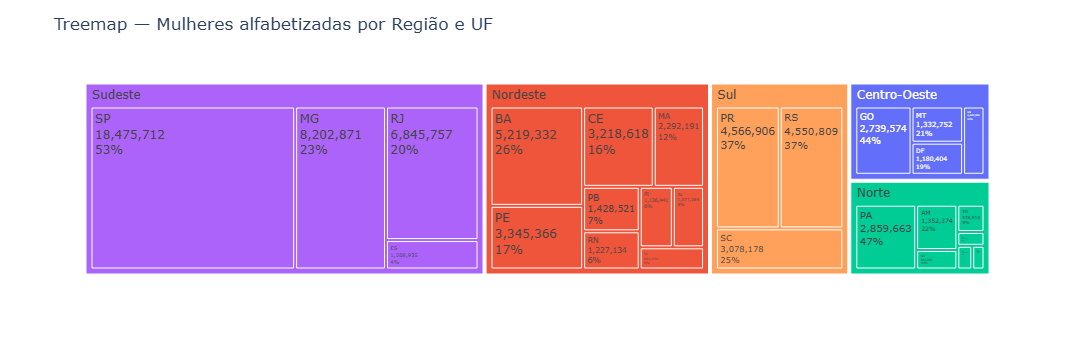

In [21]:
# Filtrar somente mulheres alfabetizadas por UF 
df_mulheres = df_censo[df_censo['sexo'] == 'Mulheres'].copy()
df_mulheres['populacao'] = pd.to_numeric(df_mulheres['populacao'], errors='coerce').fillna(0)

df_alfa = (
    df_mulheres[df_mulheres['alfabetizacao'] == 'Alfabetizadas']
    .groupby(['region', 'sigla_uf'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_alfabetizadas'})
)

# Totais por região (para percentuais)
region_totals = df_alfa.groupby('region', as_index=False)['populacao_alfabetizadas'].sum().rename(columns={'populacao_alfabetizadas':'region_total'})
df_alfa = df_alfa.merge(region_totals, on='region', how='left')
df_alfa['pct_da_regiao'] = df_alfa['populacao_alfabetizadas'] / df_alfa['region_total']

# Coluna formatada para hover
df_alfa['hover_pct'] = (df_alfa['pct_da_regiao'] * 100).round(2).astype(str) + '%'

# Plot
fig = px.treemap(
    df_alfa,
    path=['region', 'sigla_uf'],
    values='populacao_alfabetizadas',
    color='region',                     # cores por região
    hover_data={'populacao_alfabetizadas': True, 'hover_pct': True, 'region_total': False, 'region': False}
)
fig.update_traces(textinfo='label+value+percent parent')  # mostra label, valor e % relativo ao pai
fig.update_layout(title='Treemap — Mulheres alfabetizadas por Região e UF')
fig.show()

### 3- Desigualdades raciais entre mulheres alfabetizadas**

Perguntas selecionadas:

8. **Em quais regiões a desigualdade racial entre mulheres alfabetizadas é mais intensa?**
9. **Existe uma “correlação regional” entre proporção racial de mulheres e menor alfabetização feminina?**

**Objetivo:**
Mostrar que desigualdade racial não é homogênea — é territorial.
Aqui entram correlações, heatmaps, clusters.

In [22]:
# Funções utilitárias (Gini ponderado)
def weighted_gini(values, weights):
    """
    O Gini é usado para medir desigualdade de renda, mas serve igualmente para desigualdade de taxas 
    de alfabetização entre grupos raciais.
    
    Gini coefficient weighted.
    values: array-like of values (ex: taxas por grupo)
    weights: array-like of weights (ex: população feminina do grupo)
    """

def weighted_gini(values, weights):
    v = np.array(values, dtype=float)
    w = np.array(weights, dtype=float)

    mask = (w > 0) & (~np.isnan(v))
    v = v[mask]
    w = w[mask]

    if len(v) == 0:
        return np.nan

    order = np.argsort(v)
    v = v[order]
    w = w[order]

    cumw = np.cumsum(w)
    cumv = np.cumsum(v * w)

    sumw = cumw[-1]
    sumvw = cumv[-1]

    if sumw == 0 or sumvw == 0:
        return np.nan

    relcumw = cumw / sumw
    relcumv = cumv / sumvw

    B = np.sum(relcumv[:-1] * (relcumw[1:] - relcumw[:-1]))
    G = 1 - 2 * B

    return float(G)

In [23]:
# Criar df_bq 
df_base = df_censo.copy()

# garantir formato
df_base['populacao'] = pd.to_numeric(df_base['populacao'], errors='coerce').fillna(0)

# MULHERES alfabetizadas por UF x raça
df_mulheres_alf = (
    df_base[
        (df_base['sexo'] == 'Mulheres') &
        (df_base['alfabetizacao'] == 'Alfabetizadas')
    ]
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_mulheres'})
)

# TOTAL de MULHERES por UF x raça
df_mulheres_total = (
    df_base[df_base['sexo'] == 'Mulheres']
    .groupby(['sigla_uf', 'cor_raca'], as_index=False)['populacao']
    .sum()
    .rename(columns={'populacao': 'populacao_total'})
)

# JUNTAR → formar df_bq
df_bq = df_mulheres_total.merge(
    df_mulheres_alf,
    on=['sigla_uf', 'cor_raca'],
    how='left'
)

df_bq['populacao_mulheres'] = df_bq['populacao_mulheres'].fillna(0).astype(int)
df_bq['populacao_total'] = df_bq['populacao_total'].astype(int)

# taxa (opcional, seu código recalcula depois)
df_bq['taxa_alf_fem'] = df_bq['populacao_mulheres'] / df_bq['populacao_total'].replace({0: np.nan})

df_bq.head()


,sigla_uf,cor_raca,populacao_total,populacao_mulheres,taxa_alf_fem
0,AC,Amarela,892,814,0.912556
1,AC,Branca,65765,60307,0.917008
2,AC,Indígena,7798,5478,0.702488
3,AC,Parda,206223,184096,0.892704
4,AC,Preta,25983,21924,0.843782


A avaliação dos indicadores de variação da alfabetização entre grupos raciais revela padrões regionais distintos no Brasil. 

O Sudeste apresenta o cenário mais homogêneo, com o menor range (0,07) e menor desvio padrão, indicando que as diferenças de alfabetização entre raças são pouco expressivas. Essa região combina alta média de alfabetização (0,95) com o menor nível de desigualdade ponderada (gini = 0,42), demonstrando um ambiente educacional relativamente equilibrado.

No extremo oposto, o Norte exibe a maior amplitude entre as taxas raciais (range de 0,16) e o maior coeficiente de variação, evidenciando desigualdades raciais mais acentuadas na alfabetização. Apesar de sua média ainda ser elevada (0,90), a dispersão interna indica que determinados grupos raciais estão mais distantes dos demais em termos de acesso ou permanência nos processos educacionais.

O Sul, embora apresente diferenças absolutas menores entre raças (range de 0,11), registra o maior índice de desigualdade ponderada pela população (gini = 0,60). Isso sugere que pequenas diferenças relativas ganham relevância quando consideradas as proporções populacionais dos grupos raciais, ampliando seu impacto social. Ou seja, a desigualdade no Sul não é grande em magnitude, mas é mais significativa porque afeta grupos populacionalmente relevantes.

No Centro-Oeste, os indicadores revelam um quadro intermediário: desigualdade moderada (range de 0,14) e média alta (0,93). Já o Nordeste apresenta a menor média de alfabetização (0,86) entre as regiões, mas paradoxalmente, uma das menores desigualdades entre raças. Isso indica que, na região, a limitação da alfabetização afeta grupos raciais de forma mais uniforme, produzindo menor disparidade interna apesar de um desempenho global inferior.

Em síntese, as regiões brasileiras demonstram padrões distintos:

* Sudeste: alta alfabetização + baixa desigualdade.

* Norte: maior desigualdade real entre raças.

* Sul: desigualdade ponderada elevada, impactando mais grupos majoritários.

* Centro-Oeste: cenário intermediário.

* Nordeste: desigualdade baixa, mas nível geral de alfabetização mais frágil.

Esse conjunto de resultados evidencia que o comportamento da desigualdade racial na alfabetização não depende apenas do nível médio, mas também da estrutura populacional e da forma como grupos raciais se distribuem em cada região.


In [24]:

# DESIGUALDADE RACIAL ENTRE MULHERES ALFABETIZADAS POR REGIÃO


df_bq['region'] = df_bq['sigla_uf'].map(uf_to_region)


# Taxa de alfabetização feminina por raça 

# Fórmula:
# taxa_alf_fem = populacao_mulheres / populacao_total

df_bq['taxa_alf_fem'] = (
    df_bq['populacao_mulheres'] /
    df_bq['populacao_total'].replace({0: np.nan})
)


# Agregação por REGIÃO x RAÇA com pesos populacionais

grp = (
    df_bq
    .groupby(['region', 'cor_raca'], as_index=False)
    .agg({
        'populacao_mulheres': 'sum',
        'populacao_total': 'sum'
    })
)

grp['taxa_alf_fem_raca'] = (
    grp['populacao_mulheres'] /
    grp['populacao_total'].replace({0: np.nan})
)


# Cálculo das métricas de desigualdade racial por região

results = []

for region, g in grp.groupby('region'):
    taxas = g['taxa_alf_fem_raca'].values
    pesos = g['populacao_total'].values  # usar população total como peso

    rng = np.nanmax(taxas) - np.nanmin(taxas)
    std = np.nanstd(taxas)
    mean = np.nanmean(taxas)
    cv = std / mean if mean > 0 else np.nan
    gini = weighted_gini(taxas, pesos)

    results.append({
        'region': region,
        'range': rng,
        'std': std,
        'mean': mean,
        'cv': cv,
        'gini_weighted': gini,
        'num_racas': len(g)
    })

df_desigualdade = pd.DataFrame(results).sort_values('gini_weighted', ascending=False)

display(df_desigualdade)



,region,range,std,mean,cv,gini_weighted,num_racas
4,Sul,0.110629,0.038682,0.941157,0.041101,0.602471,5
2,Norte,0.161212,0.058120,0.904825,0.064233,0.517445,5
1,Nordeste,0.075766,0.029096,0.865993,0.033598,0.447383,5
0,Centro-Oeste,0.137719,0.048831,0.931357,0.052430,0.426971,5
3,Sudeste,0.070156,0.024489,0.951840,0.025728,0.420958,5


### 4- Acesso à educação por raça (microdados da educação básica)**

Perguntas selecionadas:

. **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**
. **Existe diferença racial na trajetória educacional feminina ao longo dos níveis?**

**Objetivo:**
Mostrar que a desigualdade *começa antes* da alfabetização.
Explicar caminhos educacionais desiguais.

####  **A diferença de matrícula por raça é maior nos anos iniciais, finais do fundamental ou no ensino médio?**

Ao aprofundar a análise estatística das matrículas por raça, identifiquei que a desigualdade racial não é apenas um detalhe, mas um elemento estrutural que se manifesta logo nos primeiros anos do Ensino Fundamental.

 Calculei indicadores de dispersão para todas as regiões e os resultados foram consistentes: é no **Fundamental I** que os valores de amplitude, desvio padrão, índice de Gini e, sobretudo, o **coeficiente de variação** atingem os seus níveis máximos. Isso indica-me que a distribuição racial das matrículas é mais desigual justamente na 'porta de entrada' da escola.

 Curiosamente, notei que essa desigualdade tende a estabilizar-se nos anos finais e no Ensino Médio, o que sugere que o sistema educacional gere a desigualdade existente, mas não corrige as disparidades herdadas na etapa inicial.

 **Análise de Transição e Permanência**

 Para entender quem 'sobrevive' no sistema, medi a taxa de permanência (transição) em dois saltos críticos:
 1.  Do Fundamental I para o Fundamental II.
 2.  Do Fundamental II para o Ensino Médio.

 Os dados evidenciam uma clara hierarquia racial na permanência escolar feminina:
 * **Mulheres Brancas:** Apresentam as maiores taxas de transição em todas as regiões.
 * **Mulheres Pardas:** Situam-se num patamar intermediário.
 * **Mulheres Pretas e Indígenas:** Enfrentam os maiores desafios, apresentando as piores taxas de continuidade. A queda é particularmente acentuada no 'salto' do Fundamental II para o Ensino Médio.

Embora as mulheres, como um todo, tenham maior participação geral nas matrículas, a minha análise demonstra que as desigualdades raciais fraturam o grupo feminino. Enquanto as meninas brancas mantêm as melhores taxas de progressão, as meninas pretas e indígenas sofrem as maiores quedas.

Concluo, portanto, que não existe uma trajetória feminina homogênea: a permanência escolar no Brasil é significativamente condicionada pela raça.

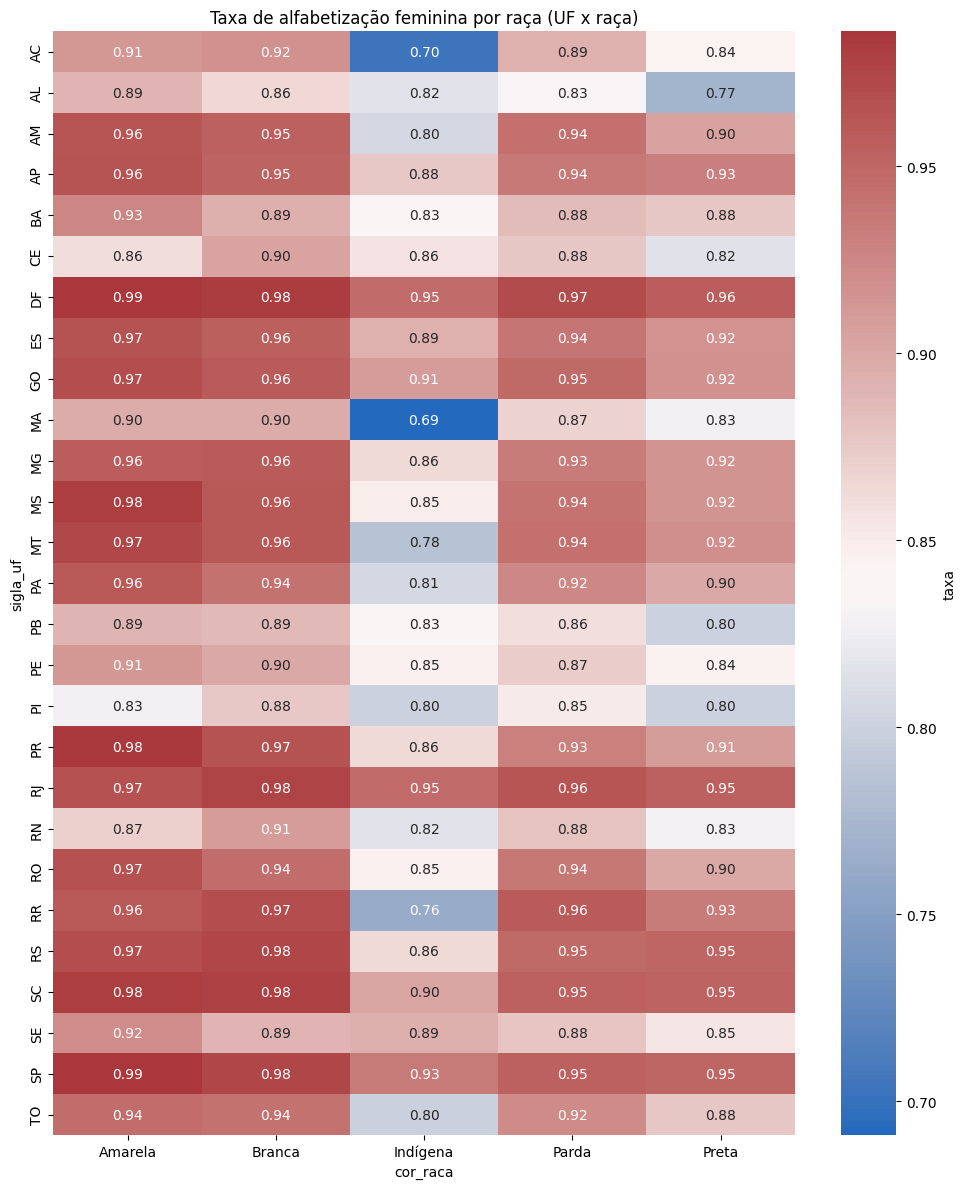

In [25]:
pivot_heat = df_bq.pivot(index='sigla_uf', columns='cor_raca', values='taxa_alf_fem')
plt.figure(figsize=(10,12))
sns.heatmap(pivot_heat, annot=True, fmt='.2f', cmap='vlag', cbar_kws={'label':'taxa'})
plt.title('Taxa de alfabetização feminina por raça (UF x raça)')
plt.tight_layout()


## Conclusão - Análise de Resultados Detalhados

### O Cenário Nacional e o "Gap" de Gênero
Ao calcular a diferença nacional de alfabetização, identifiquei que as mulheres possuem uma vantagem de aproximadamente **0,99 ponto percentual** sobre os homens (um gap de ≈ 0,00989).
Para validar a robustez deste número, apliquei a técnica de intervalo *bootstrap*, obtendo um intervalo estreito entre **0,98 e 1,00 pp**. Isso confirma que, estatisticamente, o efeito é real e preciso, embora a magnitude nacional seja baixa.

### Disparidades Regionais (O Caso do Nordeste)
A análise por UF apontou que as médias nacionais escondem profundas diferenças regionais. Observei que os maiores *gaps* favoráveis às mulheres se concentram no **Nordeste**, onde as diferenças são estatisticamente significativas (p≈0) e de alta magnitude prática. Os destaques incluem:
* **Rio Grande do Norte:** 5,34 pp
* **Paraíba:** 5,18 pp
* **Piauí:** 4,63 pp
* **Ceará:** 4,52 pp
* **Maranhão:** 3,87 pp

Em contrapartida, nas capitais, onde as taxas de alfabetização superam os 90% em praticamente todos os casos, as diferenças de gênero tornam-se muito pequenas, sendo pouco relevantes para a formulação de políticas públicas focadas apenas nesta distinção.

### A Desigualdade Racial no Território
Identifiquei que a desigualdade racial entre mulheres não é uniforme; ela possui uma forte componente territorial:
* **Sudeste:** Apresenta o melhor cenário, combinando alta média de alfabetização com menor desigualdade entre raças.
* **Norte:** Foi onde encontrei a maior amplitude entre raças, indicando uma desigualdade real e acentuada.
* **Sul:** Apesar de índices gerais altos, o *Gini ponderado* mostrou-se elevado, sugerindo uma desigualdade relevante quando consideramos o impacto populacional.
* **Nordeste:** Apresenta a média de alfabetização mais baixa (0,86), mas, curiosamente, uma desigualdade interna menor. Isso indica que a baixa alfabetização na região atinge os diferentes grupos raciais de forma mais uniforme.


In [26]:
# Agregação inicial por UF / sexo / alfabetização
# prepara tabela por UF
agg = df_censo.groupby(['sigla_uf','sexo','alfabetizacao'])['populacao'].sum().unstack(fill_value=0).reset_index()
# renomeia colunas
agg = agg.rename(columns={'Alfabetizadas':'alf', 'Não alfabetizadas':'nao_alf'})

# Loop por UF: teste z de proporções e construção de tabela df_uf_stats
# monta por UF os counts
uf_stats = []
for uf, g in agg.groupby('sigla_uf'):
    try:
        m = g[g['sexo']=='Mulheres']
        h = g[g['sexo']=='Homens']
        count = np.array([int(m['alf'].sum()), int(h['alf'].sum())])
        nobs = np.array([int(m['alf'].sum() + m['nao_alf'].sum()), int(h['alf'].sum() + h['nao_alf'].sum())])
        stat, pval = proportions_ztest(count, nobs)
        gap = count[0]/nobs[0] - count[1]/nobs[1]
        uf_stats.append({'sigla_uf': uf, 'taxa_mul': count[0]/nobs[0], 'taxa_hom': count[1]/nobs[1],
                         'gap': gap, 'z': stat, 'pval': pval})
    except Exception:
        pass

df_uf_stats = pd.DataFrame(uf_stats).sort_values('gap', ascending=False)
df_uf_stats.head(10)


# Função de bootstrap para o gap 
def bootstrap_gap_simple(df, uf=None, nboot=1000, seed=42):
    rng = np.random.default_rng(seed)
    sub = df.copy() if uf is None else df[df['sigla_uf']==uf].copy()
    groups = sub.groupby(['sexo','alfabetizacao'])['populacao'].sum().reset_index()
    base = groups.set_index(['sexo','alfabetizacao'])['populacao'].to_dict()
    tot = sum(base.values())
    probs = {k: v/tot for k,v in base.items()}

    gaps = []
    for _ in range(nboot):
        # multinomial sample of total persons
        samp = rng.multinomial(tot, list(probs.values()))
        # map back to table order
        idx = list(probs.keys())
        dic = {idx[i]: samp[i] for i in range(len(idx))}
        # compute taxas
        mul_alf = dic.get(('Mulheres','Alfabetizadas'),0)
        mul_tot = sum(dic.get(('Mulheres',lab),0) for lab in ['Alfabetizadas','Não alfabetizadas'])
        hom_alf = dic.get(('Homens','Alfabetizadas'),0)
        hom_tot = sum(dic.get(('Homens',lab),0) for lab in ['Alfabetizadas','Não alfabetizadas'])
        taxa_mul = mul_alf / mul_tot if mul_tot>0 else np.nan
        taxa_hom = hom_alf / hom_tot if hom_tot>0 else np.nan
        gaps.append(taxa_mul - taxa_hom)
    return np.nanpercentile(gaps, [2.5,50,97.5])


bootstrap_gap_simple(df_censo, uf=None)


ci_nat = bootstrap_gap_simple(df_censo, uf=None, nboot=2000)
print("Gap nacional (pp):", bootstrap_gap_simple(df_censo, uf=None)*100)  # em pontos percentuais

# adicionar CI por UF (cuidado: custoso)
def add_ci_row(row):
    uf = row['sigla_uf']
    low, med, high = bootstrap_gap_simple(df_censo, uf=uf, nboot=1000)
    return pd.Series({'ci_low': low, 'ci_med': med, 'ci_high': high})

# calcular só para top/bottom UFs (ex.: as 10 primeiras)
sample_ufs = df_uf_stats['sigla_uf'].head(10).tolist()
ci_list = []
for uf in sample_ufs:
    ci = bootstrap_gap_simple(df_censo, uf=uf, nboot=1000)
    ci_list.append({'sigla_uf':uf,'ci_low':ci[0],'ci_med':ci[1],'ci_high':ci[2]})
df_ci = pd.DataFrame(ci_list)
df_uf_stats = df_uf_stats.merge(df_ci, on='sigla_uf', how='left')
df_uf_stats.head(10)

Gap nacional (pp): [0.98137259 0.98918022 0.99752388]


,sigla_uf,taxa_mul,taxa_hom,gap,z,pval,ci_low,ci_med,ci_high
0,RN,0.886938,0.833531,0.053407,125.646672,0.0,0.052623,0.053396,0.054249
1,PB,0.864992,0.813214,0.051778,125.256991,0.0,0.051023,0.051784,0.052646
2,PI,0.850118,0.803838,0.046280,98.553606,0.0,0.045459,0.046295,0.047258
3,CE,0.880378,0.835178,0.045200,171.435018,0.0,0.044737,0.045209,0.045766
4,MA,0.868283,0.829563,0.038720,122.590913,0.0,0.038160,0.038730,0.039405
5,SE,0.878552,0.843065,0.035488,67.722499,0.0,0.034459,0.035452,0.036513
6,AL,0.836319,0.808761,0.027557,56.056583,0.0,0.026657,0.027554,0.028552
7,PE,0.878443,0.851540,0.026902,105.413225,0.0,0.026457,0.026911,0.027460
8,PA,0.924706,0.899944,0.024762,108.430988,0.0,0.024361,0.024772,0.025242
9,BA,0.884682,0.862311,0.022372,113.084941,0.0,0.021986,0.022369,0.022761


### Nota técnica: Consistência dos Dados 
Durante o processamento dos dados do INEP, identifiquei uma inconsistência importante: em aproximadamente **164.746 registos**, a variável de total de matrículas (`QT_MAT_BAS`) discorda da soma das colunas detalhadas por raça.
*Ação:* Para esta análise, tratei estes dados com cautela, mas recomendo uma verificação ou ajuste de base antes de realizar estudos que exijam precisão fina na granularidade racial do Censo Escolar.